In [1]:
import matplotlib
import matplotlib.pyplot as plt

In [22]:
import json
import requests
from dateutil.parser import parse
from collections import defaultdict
from datetime import datetime, timezone, timedelta

class API:
    url = f"https://api.luchtmeetnet.nl/open_api/measurements"

    def get(self, station=None, start=None, end=None, formula=None):
        request_url = self.url

        # blegh - query string params
        # TODO something with station
        qsp_to_add = ["station_number=NL10404"]

        if start and end:
            qsp_to_add.append(f"start={start}")
            qsp_to_add.append(f"end={end}")
        if formula:
            qsp_to_add.append(f"formula={formula}")

        if len(qsp_to_add) > 0:
            stuff = "&".join(qsp_to_add)
            request_url += f"?{stuff}"

#         print(request_url)

        try:
            response = requests.get(request_url)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print('Something went wrong while getting data from api: ', e)
            return []

        response_json = response.json()

        if 'pagination' in response_json:
            current_page = response_json['pagination']['current_page']
            last_page = response_json['pagination']['last_page']
            if current_page != last_page:
                print("TODO - pagination needed")
#                 print(response_json)

        response_data = response_json['data']

        return response_data

class LuchtmeetnetData:

    metrics = dict()
    measurements = defaultdict(dict)
    api = API()

    def __init__(self, formulas):
        for formula in formulas:
            self.metrics[formula] = Metric(formula)

    def add(self, data):
#         print("adding data")
        for item in data:
            formula = item['formula']
            value = item['value']
            timestamp = item['timestamp_measured']
#             print(f"Adding: {timestamp}, {formula}, {value}")

            metric = self.metrics[formula]

            self.measurements[formula][timestamp] = Measurement(metric, value, timestamp)

    def get_timestamp(self, metric, timestamp):
        if timestamp in self.measurements[metric]:
#             print("already there")
            delta_measurement = self.measurements[metric][timestamp]
            return delta_measurement
        else:
            print(f"api call for {start}")
            new_data = self.api.get(start=timestamp, end=timestamp)
            
            if len(new_data) > 0:
                self.add(new_data)
                return self.get_timestamp(metric, timestamp)
            return None
    
    def get_time_range(self, start, end, metric):
        measurements_range = []
        
        dt_start, dt_end = parse(start), parse(end)
        
        dt_timestamp = dt_start
        
        while dt_timestamp <= dt_end:
            timestamp = dt_timestamp.isoformat()
            
#             print(timestamp)

            if timestamp in self.measurements[metric]:
#                 print("already there")
                measurements_range.append(self.measurements[metric][timestamp])
            else:
#                 print(f"api call for range {start}-{end}")
                new_data = self.api.get(start=dt_start.isoformat(), end=dt_end.isoformat())

                if len(new_data) > 0:
                    self.add(new_data)
#                     print(f"New data: {new_data}, for {timestamp}")
                    # ugly, but I don't want to keep looping
#                     print(f"measurements: {self.measurements[metric]}")
                    if timestamp in self.measurements[metric]:
#                         print("hello")
                        measurements_range.append(self.measurements[metric][timestamp])
                    else:
#                         print(f"skipping {metric}, {timestamp}")
                        measurements_range.append(Measurement(metric, None, timestamp)) # makes plotting life easier, but will regret this - probably

            dt_timestamp = dt_timestamp + timedelta(hours=1)
        
        return measurements_range

    def get_current_report(self):
        the_report = defaultdict(dict)
        timestamp = datetime.now(timezone.utc).replace(minute=0, second=0, microsecond=0).isoformat()

        for metric in self.measurements:
            current_measurement = self.measurements[metric][timestamp]
            the_report[metric]["NOW"] = current_measurement.evaluate()

            for enum, time_delta in time_deltas:
                result_time = current_measurement.timestamp - time_delta
                delta_time_string = result_time.isoformat()

                delta_measurement = self.get_timestamp(metric, delta_time_string)
                the_report[metric][enum] = current_measurement.compare(delta_measurement)

        return the_report

class Metric:
    metric_types = dict()
    metric_types['NO2'] = {'ub_good': 30, 'ub_med': 80, 'ub_bad': 100}
    metric_types['NO'] = {'ub_good': 30, 'ub_med': 100}
    metric_types['O3'] = {'ub_good': 40, 'ub_med': 180}
    metric_types['PM10'] = {'ub_good': 30, 'ub_med': 70, 'ub_bad': 100}
    metric_types['PM25'] = {'ub_good': 20, 'ub_med': 50, 'ub_bad': 100}

    ub_bad = float('inf') # why not?

    def __repr__(self):
        return f"<Metric: {self.formula}>"

    def __init__(self, formula):
        self.formula = formula
        metric_info = self.metric_types[self.formula]
        if 'ub_good' in metric_info:
            self.ub_good = metric_info['ub_good']
        if 'ub_med' in metric_info:
            self.ub_med = metric_info['ub_med']
        if 'ub_bad' in metric_info:
            self.ub_bad = metric_info['ub_bad']

    def judgement(self, value):
        if value <= self.ub_good:
            return "GOOD"
        elif value <= self.ub_med:
            return "MEDIOCRE"
        elif value <= self.ub_bad:
            return "BAD"
        else:
            return f"PANIC - {value}"

class Measurement:

    def __repr__(self):
        return f"<Measurement: {self.metric.formula}, {self.value}, {self.timestamp}>"

    def __init__(self, metric, value, timestamp):
        self.metric = metric
        if value:
            self.value = float(value) # better safe than sorry
        else:
            self.value = None
        self.timestamp = parse(timestamp)

    def evaluate(self):
        judgement = self.metric.judgement(self.value)
        return judgement

    def compare(self, other_measurement):
        diff = self.value - other_measurement.value
        return diff


In [23]:
# CONFIG
formulas = ['PM10', 'PM25', 'NO2', 'NO', 'O3']

time_deltas = []
time_deltas.append(("ONE_HOUR", timedelta(hours=1))) # one hour
time_deltas.append(("ONE_DAY", timedelta(days=1))) # one day
time_deltas.append(("ONE_WEEK", timedelta(days=7))) # one day
time_deltas.append(("ONE_MONTH", timedelta(days=30))) # one day
time_deltas.append(("ONE_YEAR", timedelta(days=365))) # one day

data = LuchtmeetnetData(formulas)

event_one = datetime(2019, 4, 25, 21, 2, 0, tzinfo=timezone.utc)
event_two = datetime(2020, 1, 15, 5, 5, 0, tzinfo=timezone.utc)
event_three = datetime(2020, 6, 18, 10, 28, 0, tzinfo=timezone.utc)

events = [event_one, event_two, event_three]

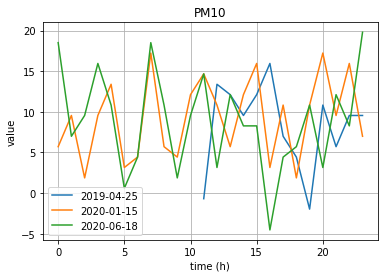

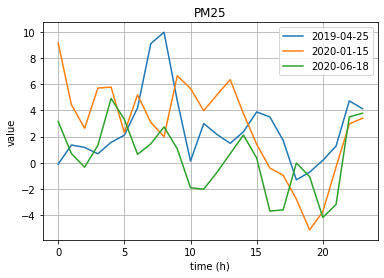

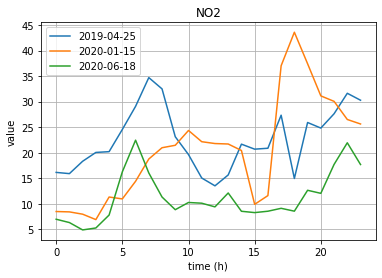

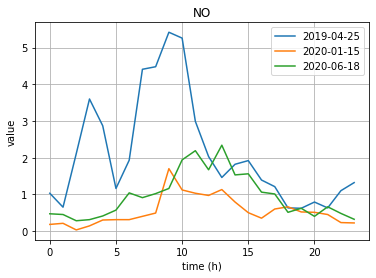

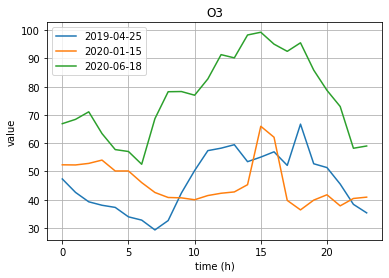

In [31]:
for metric in formulas:

    fig, ax = plt.subplots()


    for event in events:
        start_time = event.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
        end_time = event.replace(hour=23, minute=0, second=0, microsecond=0).isoformat()

        values = data.get_time_range(start_time, end_time, metric)
        values = sorted(values, key = lambda x: x.timestamp)


        xs = list(range(24))
        ys = [x.value for x in values]
    #     print(xs)
    #     print(ys)

        ax.plot(xs, ys, label=f"{event.date()}")

    ax.set(xlabel='time (h)', ylabel='value',
           title=f'{metric}')

    ax.grid()
    ax.legend()

    plt.show()

In [20]:
event.date()

datetime.date(2019, 4, 25)